# 1. Install and Import Dependencies

In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [2]:
# specifies a version constraint for the Protocol Buffers library. It's asking to install version 3.20.x
!pip install stable-baselines3[extra] protobuf==3.20.*

In [3]:
! pip install pytesseract
! pip install tesseract

In [4]:
!pip install mss pydirectinput

In [1]:
#chrome://dino/

In [5]:
# used for screen capture
from mss import mss
import ctypes
from ctypes import pointer, util
# send command / input
import pydirectinput
import cv2
# transformational framework
import numpy as np
# Optical Character Recognition
import pytesseract
from matplotlib import pyplot as plt
# for pauses, have break when action is going (a lay off when change action or frame)
import time

# From table Baselines 2.0.0, Gym is no longer supported, or can switch to older version of SB
# Gymnasium (Open Ai), a toolkit for developing RL algorithms
# Doc: https://gymnasium.farama.org/api/env/
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [6]:
# ref: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

# 2. Build the Environment

## 2.1 Create Environment

In [8]:
class WebGame(Env):
    # Setup the environment action and observation space
    def __init__(self):
        #This is done to ensure that any initialization code in the superclass (Env) 
        #is executed before the specific initialization code in the current class.
        super().__init__()
        # Setup spaces, shape(channel, height, width)
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}

    # Action in the game
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down',
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])
            
        # Cheking is the game done
        done, done_cap = self.get_done()
        # Get the next observation
        observation = self.get_observation()
        # get a point for every frame alive
        reward = 1
        # these 2 is fixed, SB required
        truncated = False
        info = {}
        return observation, reward, done, truncated, info

    # Restart the game
    def reset(self, seed = None):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation(), {}
    
    # visualise the game
    def render(self):
        # show the dino game
        cv2.imshow('Game', self.current_frame)
        # It waits for 1 millisecond and then checks if a key has been pressed.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def close(self):
        cv2.destroyAllWindows()

    # get the observation we want
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        # preprocessing is to compress the image to lower scale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # cv2 takes in width first then height
        resized = cv2.resize(gray, (100,83))
        # put the channel to the front (format that SB / pytorch required)
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    # get the 'game over' text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap
        

# 2.2 Test Environment

In [9]:
env = WebGame()

In [10]:
env.action_space.sample()

2

In [11]:
obs=env.get_observation()

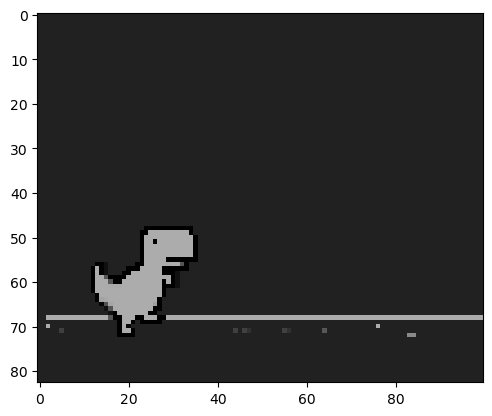

In [12]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [13]:
done, done_cap = env.get_done()

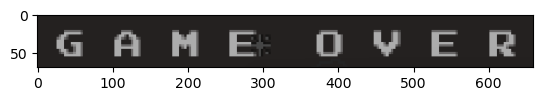

In [14]:
plt.imshow(done_cap)

In [15]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [16]:
done

True

In [17]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward   = 0
    while not done:
        obs, reward, done, truncated, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 13
Total Reward for episode 1 is 14
Total Reward for episode 2 is 13
Total Reward for episode 3 is 13
Total Reward for episode 4 is 15


# 3. Train the Model

## 3.1 Create Callback

In [18]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

In [19]:
env_checker.check_env(env)

In [20]:
# A callback is a set of functions that will be called at given stages of the training procedure.
# You can use callbacks to access internal state of the RL model during training. 
# It allows one to do monitoring, auto saving, model manipulation, etc

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [21]:
%pwd

'C:\\Users\\semee\\Downloads'

In [22]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [23]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [24]:
# import the deep Q-network (DQN) algorithm
from stable_baselines3 import DQN
#from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [25]:
env = WebGame()

In [ ]:
# Different Policy: https://stable-baselines.readthedocs.io/en/master/modules/dqn.html

# verbose (0,1,2) parameter is used to control the logging level of information during the training process.
# verbose=1: Moderate logging. It prints some basic information, such as the current training episode, 
# the total number of steps taken, and the training time.

# Buffer Size = size of the replay buffer.a replay buffer is used to store past experiences (transitions) of the agent 
# in the environment. The agent samples mini-batches of experiences from this replay buffer to learn from them during the 
# training process. A larger buffer size allows the agent to store more experiences, potentially leading to better learning. 
# However, it also comes with increased memory requirements.

In [26]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=300000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [59]:
model.learn(total_timesteps=80000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 27       |
|    total_timesteps  | 56       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.8     |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 55       |
|    total_timesteps  | 118      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 15       |
|    exploration_rate | 0.979    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.7     |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 2        |
|    time_elapsed     | 582      |
|    total_timesteps  | 1320     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000202 |
|    n_updates        | 79       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 2        |
|    time_elapsed     | 611      |
|    total_timesteps  | 1389     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000221 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.7     |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 2        |
|    time_elapsed     | 1022     |
|    total_timesteps  | 2332     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.21e-05 |
|    n_updates        | 332      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.7     |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 2        |
|    time_elapsed     | 1050     |
|    total_timesteps  | 2401     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.5     |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 2        |
|    time_elapsed     | 1469     |
|    total_timesteps  | 3408     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.46e-06 |
|    n_updates        | 601      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.587    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 2        |
|    time_elapsed     | 1495     |
|    total_timesteps  | 3474     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.17e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.474    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 2        |
|    time_elapsed     | 1906     |
|    total_timesteps  | 4427     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.23e-06 |
|    n_updates        | 856      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.1     |
|    ep_rew_mean      | 16.1     |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 2        |
|    time_elapsed     | 1933     |
|    total_timesteps  | 4488     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.07e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 2        |
|    time_elapsed     | 2341     |
|    total_timesteps  | 5449     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67e-05 |
|    n_updates        | 1112     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 2        |
|    time_elapsed     | 2368     |
|    total_timesteps  | 5512     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.28e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.233    |
| time/               |          |
|    episodes         | 404      |
|    fps              | 2        |
|    time_elapsed     | 2780     |
|    total_timesteps  | 6461     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.69e-06 |
|    n_updates        | 1365     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 2        |
|    time_elapsed     | 2809     |
|    total_timesteps  | 6528     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.55e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 2        |
|    time_elapsed     | 3212     |
|    total_timesteps  | 7510     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.9e-06  |
|    n_updates        | 1627     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.0999   |
| time/               |          |
|    episodes         | 472      |
|    fps              | 2        |
|    time_elapsed     | 3239     |
|    total_timesteps  | 7580     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.83e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 2        |
|    time_elapsed     | 3648     |
|    total_timesteps  | 8589     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.98e-06 |
|    n_updates        | 1897     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 2        |
|    time_elapsed     | 3674     |
|    total_timesteps  | 8643     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.22e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 596      |
|    fps              | 2        |
|    time_elapsed     | 4087     |
|    total_timesteps  | 9653     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.49e-06 |
|    n_updates        | 2163     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 2        |
|    time_elapsed     | 4113     |
|    total_timesteps  | 9719     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.67e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 2        |
|    time_elapsed     | 4536     |
|    total_timesteps  | 10721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates        | 2430     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.1     |
|    ep_rew_mean      | 17.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 664      |
|    fps              | 2        |
|    time_elapsed     | 4562     |
|    total_timesteps  | 10810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00242  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 724      |
|    fps              | 2        |
|    time_elapsed     | 4962     |
|    total_timesteps  | 11841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000678 |
|    n_updates        | 2710     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 2        |
|    time_elapsed     | 4988     |
|    total_timesteps  | 11914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00106  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 788      |
|    fps              | 2        |
|    time_elapsed     | 5391     |
|    total_timesteps  | 12972    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00168  |
|    n_updates        | 2992     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 2        |
|    time_elapsed     | 5417     |
|    total_timesteps  | 13051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00759  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 852      |
|    fps              | 2        |
|    time_elapsed     | 5821     |
|    total_timesteps  | 14089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000514 |
|    n_updates        | 3272     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 2        |
|    time_elapsed     | 5849     |
|    total_timesteps  | 14165    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00871  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.5     |
|    ep_rew_mean      | 17.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 916      |
|    fps              | 2        |
|    time_elapsed     | 6252     |
|    total_timesteps  | 15234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00112  |
|    n_updates        | 3558     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.5     |
|    ep_rew_mean      | 17.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 2        |
|    time_elapsed     | 6278     |
|    total_timesteps  | 15303    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00874  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 980      |
|    fps              | 2        |
|    time_elapsed     | 6679     |
|    total_timesteps  | 16375    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000356 |
|    n_updates        | 3843     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 2        |
|    time_elapsed     | 6707     |
|    total_timesteps  | 16451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 2        |
|    time_elapsed     | 7108     |
|    total_timesteps  | 17505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00221  |
|    n_updates        | 4126     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 2        |
|    time_elapsed     | 7135     |
|    total_timesteps  | 17571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000903 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 2        |
|    time_elapsed     | 7531     |
|    total_timesteps  | 18632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00598  |
|    n_updates        | 4407     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 2        |
|    time_elapsed     | 7557     |
|    total_timesteps  | 18707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000512 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 2        |
|    time_elapsed     | 7961     |
|    total_timesteps  | 19773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00296  |
|    n_updates        | 4693     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18       |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 2        |
|    time_elapsed     | 7990     |
|    total_timesteps  | 19876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00614  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.9     |
|    ep_rew_mean      | 21.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 2        |
|    time_elapsed     | 8506     |
|    total_timesteps  | 21302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00158  |
|    n_updates        | 5075     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 2        |
|    time_elapsed     | 8548     |
|    total_timesteps  | 21437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00848  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | 29.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 2        |
|    time_elapsed     | 9145     |
|    total_timesteps  | 23266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00343  |
|    n_updates        | 5566     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | 29.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 2        |
|    time_elapsed     | 9182     |
|    total_timesteps  | 23367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000703 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 31.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 2        |
|    time_elapsed     | 9810     |
|    total_timesteps  | 25249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 6062     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 30.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 2        |
|    time_elapsed     | 9852     |
|    total_timesteps  | 25363    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 30.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 2        |
|    time_elapsed     | 10467    |
|    total_timesteps  | 27209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00342  |
|    n_updates        | 6552     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 31       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 2        |
|    time_elapsed     | 10513    |
|    total_timesteps  | 27350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00523  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 31.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 2        |
|    time_elapsed     | 11133    |
|    total_timesteps  | 29232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000368 |
|    n_updates        | 7057     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 31.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 2        |
|    time_elapsed     | 11176    |
|    total_timesteps  | 29354    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 2        |
|    time_elapsed     | 11800    |
|    total_timesteps  | 31310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 7577     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 2        |
|    time_elapsed     | 11851    |
|    total_timesteps  | 31496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 36.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 2        |
|    time_elapsed     | 12521    |
|    total_timesteps  | 33745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 8186     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 2        |
|    time_elapsed     | 12563    |
|    total_timesteps  | 33872    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0844   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 37.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 2        |
|    time_elapsed     | 13245    |
|    total_timesteps  | 36101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates        | 8775     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 37       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 2        |
|    time_elapsed     | 13287    |
|    total_timesteps  | 36228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0038   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 2        |
|    time_elapsed     | 13943    |
|    total_timesteps  | 38444    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0641   |
|    n_updates        | 9360     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 2        |
|    time_elapsed     | 13986    |
|    total_timesteps  | 38578    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0231   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 2        |
|    time_elapsed     | 14612    |
|    total_timesteps  | 40537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0198   |
|    n_updates        | 9884     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 2        |
|    time_elapsed     | 14658    |
|    total_timesteps  | 40675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0212   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 29.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 2        |
|    time_elapsed     | 15269    |
|    total_timesteps  | 42430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0702   |
|    n_updates        | 10357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | 29.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 2        |
|    time_elapsed     | 15309    |
|    total_timesteps  | 42545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0263   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 29.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 2        |
|    time_elapsed     | 15951    |
|    total_timesteps  | 44397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00658  |
|    n_updates        | 10849    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 30.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 2        |
|    time_elapsed     | 15994    |
|    total_timesteps  | 44549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00922  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | 28.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 2        |
|    time_elapsed     | 16575    |
|    total_timesteps  | 46201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00578  |
|    n_updates        | 11300    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | 28.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 2        |
|    time_elapsed     | 16609    |
|    total_timesteps  | 46305    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 30.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 2        |
|    time_elapsed     | 17241    |
|    total_timesteps  | 48188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0656   |
|    n_updates        | 11796    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 30.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 2        |
|    time_elapsed     | 17285    |
|    total_timesteps  | 48324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 30.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 2        |
|    time_elapsed     | 17894    |
|    total_timesteps  | 50136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 12283    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 30.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 2        |
|    time_elapsed     | 17937    |
|    total_timesteps  | 50278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.102    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 31.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 2        |
|    time_elapsed     | 18591    |
|    total_timesteps  | 52262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 12815    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 31.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 2        |
|    time_elapsed     | 18624    |
|    total_timesteps  | 52359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 2        |
|    time_elapsed     | 19274    |
|    total_timesteps  | 54336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0491   |
|    n_updates        | 13333    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 32.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 2        |
|    time_elapsed     | 19314    |
|    total_timesteps  | 54452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00312  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 33       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 2        |
|    time_elapsed     | 19985    |
|    total_timesteps  | 56489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 13872    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 33.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 2        |
|    time_elapsed     | 20029    |
|    total_timesteps  | 56626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0444   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 2        |
|    time_elapsed     | 20681    |
|    total_timesteps  | 58547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0998   |
|    n_updates        | 14386    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 2        |
|    time_elapsed     | 20727    |
|    total_timesteps  | 58685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.9     |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 2        |
|    time_elapsed     | 21375    |
|    total_timesteps  | 60669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 14917    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 2        |
|    time_elapsed     | 21412    |
|    total_timesteps  | 60781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00628  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 34.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2516     |
|    fps              | 2        |
|    time_elapsed     | 22085    |
|    total_timesteps  | 62969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 15492    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 35.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 2        |
|    time_elapsed     | 22130    |
|    total_timesteps  | 63116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00205  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 2        |
|    time_elapsed     | 22834    |
|    total_timesteps  | 65376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates        | 16093    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | 37.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 2        |
|    time_elapsed     | 22870    |
|    total_timesteps  | 65508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0323   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 35.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 2        |
|    time_elapsed     | 23515    |
|    total_timesteps  | 67538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates        | 16634    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.1     |
|    ep_rew_mean      | 35.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 2        |
|    time_elapsed     | 23558    |
|    total_timesteps  | 67650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0108   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2708     |
|    fps              | 2        |
|    time_elapsed     | 24253    |
|    total_timesteps  | 69883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 17220    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 2        |
|    time_elapsed     | 24300    |
|    total_timesteps  | 70030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2772     |
|    fps              | 2        |
|    time_elapsed     | 24970    |
|    total_timesteps  | 72149    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00924  |
|    n_updates        | 17787    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 34.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 2        |
|    time_elapsed     | 25005    |
|    total_timesteps  | 72236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2836     |
|    fps              | 2        |
|    time_elapsed     | 25669    |
|    total_timesteps  | 74254    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 18313    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 2        |
|    time_elapsed     | 25708    |
|    total_timesteps  | 74357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.174    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 31.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 2        |
|    time_elapsed     | 26339    |
|    total_timesteps  | 76266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 18816    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 2        |
|    time_elapsed     | 26383    |
|    total_timesteps  | 76409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00597  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2964     |
|    fps              | 2        |
|    time_elapsed     | 27032    |
|    total_timesteps  | 78431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0171   |
|    n_updates        | 19357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 2        |
|    time_elapsed     | 27088    |
|    total_timesteps  | 78614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates      

# 4. Test out Model

In [53]:
# ref: https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#basic-usage-training-saving-loading
model = DQN.load('./train/best_model_80000',env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [54]:
# https://github.com/DLR-RM/  stable-baselines3/issues/1694
for episode in range(3):
    vec_env = model.get_env()
    obs = vec_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(int(action))
        #time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    #time.sleep(2)

Total Reward for episode 0 is 36
Total Reward for episode 1 is 30
Total Reward for episode 2 is 32


Enhancement
1) Can try changing the reward system. Such as -1 for any action and +2 for inaction.
2) Different way or approaches to capture the game over frame (to increase the fps)
3) Different algorithms? Like different DQN network.
4) Build your own reinforcement agent as stable baseline is quite limited.